In [1]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import os
from os.path import isfile
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import glob
%matplotlib inline

In [2]:
meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
maskName='tmask'

In [3]:
j0=230;j1=470;i0=0;i1=200;
ct=240;cz=40;cy=50;cx=200;

In [4]:
def prepro(ds):
    return ds.loc[dict(y=slice(j0,j1),x=slice(i0,i1))]

In [5]:
mesh=xr.open_mfdataset(meshPath,chunks={'t':1, 'z':cz, 'y':cy, 'x':cx},preprocess=prepro,parallel=True)

In [6]:
mesh2=mesh.loc[{'z':0}]

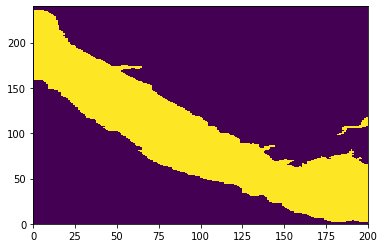

In [7]:
plt.pcolormesh(mesh2['tmask'].squeeze())

In [8]:
flistHC=et.index_model_files(dt.datetime(2015,7,10),dt.datetime(2015,8,8),
                             '/results/SalishSea/hindcast.201905/',
                             'nowcast',1,'ptrc_T',1)
flistmuZ=et.index_model_files(dt.datetime(2015,7,10),dt.datetime(2015,8,8),
                             '/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/',
                             'long',10,'ptrc_T',1)

In [9]:
t0=dt.datetime.now()
dataHC=xr.open_mfdataset(flistHC['paths'],data_vars=('diatoms','microzooplankton'),chunks={'time_counter':ct, 'deptht':cz, 'y':cy, 'x':cx},
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),preprocess=prepro,parallel=True)
t1=dt.datetime.now()
print(t1-t0)

0:00:12.210181


In [10]:
dataHC

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 720, x: 200, y: 240)
Coordinates:
    nav_lat               (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lon               (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(720,), chunksize=(24,)>
  * time_counter          (time_counter) datetime64[ns] 2015-07-10T00:30:00 ... 2015-08-08T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bounds_lat            (y, x, nvertex) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    deptht_bounds         (deptht, axis_nbounds) float32 0.0 ... 454.93237
    time_centered_bounds  (time_counter, ax

In [11]:
t0=dt.datetime.now()
datamuZ=xr.open_mfdataset(flistmuZ['paths'],data_vars=('diatoms','microzooplankton'),chunks={'time_counter':ct, 'deptht':cz, 'y':cy, 'x':cx},
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),preprocess=prepro,parallel=True)
t1=dt.datetime.now()
print(t1-t0)

0:00:01.314762


In [12]:
datamuZ=datamuZ.rename({'time_counter':'t','deptht':'z'})

In [13]:
datamuZ

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, nvertex: 4, t: 720, x: 200, y: 240, z: 40)
Coordinates:
    nav_lat               (y, x) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    nav_lon               (y, x) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * z                     (z) float32 0.5000003 1.5000031 ... 414.5341 441.4661
    time_centered         (t) datetime64[ns] dask.array<shape=(720,), chunksize=(240,)>
  * t                     (t) datetime64[ns] 2015-07-10T00:30:00 ... 2015-08-08T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_nav_lon        (y, x, nvertex) float32 -1.0 -1.0 -1.0 ... -1.0 -1.0
    bounds_nav_lat        (y, x, nvertex) float32 -1.0 -1.0 -1.0 ... -1.0 -1.0
    area                  (y, x) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    deptht_bounds         (z, axis_nbounds) float32 0.0 1.0000012 ... 454.93237
    time_centered_bounds  (t, axis_nbounds) datetime64[ns] dask.array<sh

In [14]:
import dask
from dask.distributed import Client, progress
import dask.array as da

In [15]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36354 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.77 GB


In [16]:
tmask=da.asanyarray(mesh['tmask']).rechunk(('auto',-1,'auto','auto'))
e3t=da.asanyarray(mesh['e3t_0']).rechunk(('auto',-1,'auto','auto'))
diatomsmuZ=da.asanyarray(datamuZ['diatoms']).rechunk(('auto',cz,'auto','auto'))
diatomsHC=da.asanyarray(dataHC['diatoms']).rechunk(('auto',cz,'auto','auto'))

In [17]:
tmask

dask.array<rechunk-merge, shape=(1, 40, 240, 200), dtype=int8, chunksize=(1, 40, 240, 200), chunktype=numpy.ndarray>

In [18]:
e3t

dask.array<rechunk-merge, shape=(1, 40, 240, 200), dtype=float64, chunksize=(1, 40, 240, 200), chunktype=numpy.ndarray>

In [19]:
diatomsmuZ

dask.array<rechunk-merge, shape=(720, 40, 240, 200), dtype=float32, chunksize=(120, 40, 25, 100), chunktype=numpy.ndarray>

In [20]:
prod1=tmask*e3t*diatomsmuZ

In [21]:
prod1

dask.array<mul, shape=(720, 40, 240, 200), dtype=float64, chunksize=(120, 40, 25, 100), chunktype=numpy.ndarray>

In [22]:
sum1=dask.array.sum(prod1,axis=1)

In [23]:
sum1

dask.array<sum-aggregate, shape=(720, 240, 200), dtype=float64, chunksize=(120, 25, 100), chunktype=numpy.ndarray>

In [24]:
diatomsmuZInt=da.mean(sum1,0)

In [25]:
prod2=tmask*e3t*diatomsHC
sum2=dask.array.sum(prod2,axis=1)
diatomsHCInt=da.mean(sum2,0)

In [26]:
#diatomsmuZInt.visualize()

In [27]:
t0=dt.datetime.now()
diatomsmuZInt=diatomsmuZInt.compute()
t1=dt.datetime.now()
print(t1-t0)

0:05:26.988297


In [28]:
t0=dt.datetime.now()
diatomsHCInt=diatomsHCInt.compute()
t1=dt.datetime.now()
print(t1-t0)

0:02:49.509352


0:00:00.379466


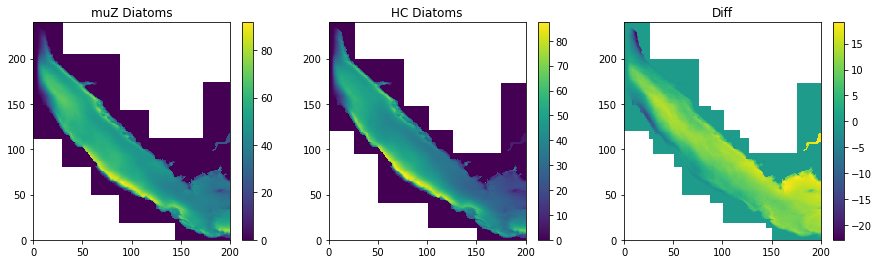

In [29]:
t0=dt.datetime.now()
fig,ax=plt.subplots(1,3,figsize=(15,4))
m0=ax[0].pcolormesh(diatomsmuZInt)
plt.colorbar(m0,ax=ax[0])
ax[0].set_title('muZ Diatoms')
m1=ax[1].pcolormesh(diatomsHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC Diatoms')
m2=ax[2].pcolormesh(diatomsmuZInt-diatomsHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')
t1=dt.datetime.now()
print(t1-t0)